# Detecting circular dsDNA in parasitoid wasps using insert size distributions

This notebook showcases validation results for the detection of circular dsDNA in parasitoid wasps using insert size distributions. The method is based on the observation that circular dsDNA molecules are expected to have a distinct insert size distribution compared to linear dsDNA molecules. When short DNA reads that straddle a circularization junction in a circular DNA are mapped back to the linear chromosome, the distance between the forward and reverse reads is expected to be equal to the length of the circular DNA molecule--much longer than you'd expect from the typical insert size distribution of a short-read DNA library. We wanted to see if it was possible to detect this pattern in parasitoid wasps, since they are known to produce multiple DNA circles. They package the circles in virus-like particles, which are injected into the host insect along with wasp eggs. The circles are thought to play a role in suppressing the host immune response. To produce the circles, segments of the wasp genome are massively amplified, excised, and circularized. Not all DNA in the amplified units (also referred to as replication units) is circularized, so we expect to find insert size positions that are nested within positions that have high coverage.

We tested our method on three parasitoid wasps:
* _Microplitis demolitor_, a braconid wasp that is the canonical example of a parasitoid wasp that produces circular DNA.
* _Cotesia congregata_, another braconid wasp that is known to produce circular DNA.
* _Hyposoter didymator_, an ichneumonid wasp that produces circular DNA.

For some of these species, we mapped multiple short-read libraries. For _Microplitis demolitor_, we mapped a library from only female wasps and another from only male wasps. Uniquely, only **female** parasitoid wasps produce circular DNA, so we expected to see a difference in insert size distributions between the male and female libraries. We mapped a male-only library to _Cotesia congregata_ to check that our method wouldn't pick up signals. For the other species, we mapped two libraries where possible to see if the insert size distribution patterns were consistent across libraries. We used the following accessions for the libraries (which can also be found in `inputs/parasitoid_wasp_samplesheet.csv`):
* _Microplitis demolitor_:
    * SRR2011474 (female wasps)
    * SRR1565751 (male wasps)
* _Hyposoter didymator_:
    * SRR24090832
    * SRR24090834
* _Cotesia congregata_:
    * ERR3829581 (male wasps)
* _Venturia canescens_:
    * ERR4873282

### Mapping short reads with the Nextflow pipeline

We used the Nextflow pipeline to map the short reads to the reference genome, generating filtered BAM files with insert sizes ≥1 kb and coverage files. After following the install instructions in the README and activating the conda environment, we ran the following command to map the reads:

```bash
nextflow run main.nf --samples inputs/parasitoid_wasp_samplesheet.csv --outdir results/parasitoid_wasps --threads 16 -resume
```

We then placed the output files into corresponding subdirectories in the `results/parasitoid_wasps` directory (`bam_files`, `coverage_files`) to make it easier to analyze the results. We also downloaded the reference genomes and annotations (if available) for each species and placed them in `inputs/parasitoid_wasps/genome_assemblies/` and `inputs/parasitoid_wasps/genome_annotations/`, respectively.

### Analyzing and visualizing the results

We analyzed the outputs with R, and included some handling functions in `scripts/insert_size_funcs.R` if you want to make similar visualizations yourself. If you have annotation data that you're interested in, we recommend using the `GenomeInfo` class and Python to process your data instead, then visualize in R.

First, load in necessary libraries, functions, and paths. 

In [1]:
library(tidyverse)
library(Rsamtools)
library(data.table)
library(patchwork)
library(arcadiathemeR)
library(gggenomes)
library(seqinr)

source("scripts/insert_size_funcs.R")

INPUTS_LOC <- "inputs/parasitoid_wasps/"
BAM_LOC <- "results/parasitoid_wasps/bam_files/"
COV_LOC <- "results/parasitoid_wasps/coverage_files/"

MICROPLITIS_PREFIX <- "GCF_026212275.2_iyMicDemo2.1a"
COTESIA_PREFIX <- "GCA_905319865.3_Cotesia_congregata_Chromosomal_scale_assembly"
VENTURIA_PREFIX <- "GCF_019457755.1_ASM1945775v1"
HYPOSOTER_PREFIX <- "GCA_037952995.1_Hdid_v2"

# Option to make plots larger in the notebook
options(repr.plot.width = 20, repr.plot.height = 20)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Posit

All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.



Attaching package: 'gggenomes'


The following object is masked from 'package:data.table':

    shift


The following objects are masked from 'package:Biostrings':

    width, width0


The following object is masked from 'package:XVector':

    width


The following objects are masked from 'package:GenomicRanges':

    shift, width


The following objects are masked from 'package:IRanges':

    shift, width


The following object is masked from 'package:S4Vectors':

    width


The following object is masked from 'package:BiocGenerics':

    width


The following object is masked from 'package:dplyr':

    pick


The following object is masked from 'package:graphics':

    layout



Attaching package: 'seqinr'


The following object is masked from 'package:Biostrings':

    translate


The following object is masked from 'package:dplyr':

    count




#### _Microplitis demolitor_

We started by analyzing the _Microplitis demolitor_ data. The genome assembly we used was high-quality, but didn't have known locations for the genes contained in circular DNA highlighted in the first assembly for this wasp. We collected a list of these gene names from [Supplementary Table S1](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004660#s5), and put them into `inputs/parasitoid_wasps/microplitis_demolitor_proviral_gene_list.tsv`. We then used the latest assembly's annotations to match gene names to find the chromosomes that contained circular DNA so we could match our insert size distributions to the locations.

In [ ]:
microplitis_annotations <- read.csv(paste0(INPUTS_LOC, "genome_annotations/", MICROPLITIS_PREFIX, "_genomic.gff"),
sep = "\t", header = FALSE, comment.char = "#")

proviral_genes <- read.csv(paste0(INPUTS_LOC, "microplitis_demolitor_proviral_gene_list.tsv"), sep = "\t")

proviral_gene_list <- paste(proviral_genes$gene_symbol, collapse = "|")

# Grab only the chromosomes, not extraneous scaffolds
microplitis_annotations_gff_clean <- microplitis_annotations %>%
filter(V3 == "gene") %>%
filter(grepl("NC", V1))

only_proviral_genes <- microplitis_annotations_gff_clean %>%
filter(grepl(proviral_gene_list, V9))

# Fetch the chormosomes with proviral genes
proviral_chromosomes <- unique(only_proviral_genes$V1)

proviral_chromosomes

While this is imperfect - only 53 of the 96 genes from the original assembly are annotated - it's still a good starting point for the analysis. Next, we loaded in the BAM files with reads that have insert sizes ≥1 kb for both the male and female libraries and combined them.

In [ ]:
microplitis_female_loc <- paste0(BAM_LOC, MICROPLITIS_PREFIX, "_vs_SRR2011474.large_inserts.bam")
microplitis_male_loc <- paste0(BAM_LOC, MICROPLITIS_PREFIX, "_vs_SRR1565751.large_inserts.bam")

microplitis_female_dt <- process_bam(microplitis_female_loc) %>% 
format_bam() %>%
mutate(sample_type = "Female")
microplitis_male_dt <- process_bam(microplitis_male_loc) %>% 
format_bam() %>%
mutate(sample_type = "Male")

microplitis_combined_dt <- rbind(microplitis_female_dt, microplitis_male_dt) %>%
mutate(is_proviral = ifelse(chromosome %in% proviral_chromosomes, "Proviral", "Non-proviral")) %>%
mutate(nice_chromosome = paste0(chromosome, " (", is_proviral, ")")) %>%
filter(grepl("NC", chromosome)) # Remove extraneous scaffolds

We can now examine insert size distributions and compare between males and females. If this method works, we should see peaks in the distribution that correspond to the circular DNA lengths, and this should only be present in females. We filter to inserts ≤100 kb, since the largest replication unit for _M. demolitor_ is roughly this size. Anything larger would be noise.

In [ ]:
microplitis_combined_dt %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000, fill = sample_type)) +
geom_density(adjust = 0.2, alpha = 0.8) +
facet_wrap(~nice_chromosome, nrow = 2) +
theme_arcadia() +
scale_fill_arcadia() +
guides(fill = guide_legend("")) +
labs(x = "Insert size (kb)", y = "Density") +
theme(legend.position = "bottom") +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100))

It's nearly impossible to see anything with the raw insert size distributions because of chromosome NC_068545.1, so we'll plot that and chromosome NC_068551.1 with their own y-axis scale.

In [ ]:
reg_density_microplitis_plt <- microplitis_combined_dt %>%
filter(isize < 100000) %>%
filter(!nice_chromosome %in% c("NC_068545.1 (Proviral)", "NC_068551.1 (Proviral)")) %>%
ggplot(aes(isize / 1000, fill = sample_type)) +
geom_density(adjust = 0.2, alpha = 0.8) +
facet_wrap(~nice_chromosome, nrow = 4, scales = "free_y") +
theme_arcadia() +
scale_fill_arcadia() +
guides(fill = guide_legend("")) +
labs(x = "Insert size (kb)", y = "Density") +
theme(legend.position = "bottom", 
axis.text.x = element_blank(), 
axis.ticks.x = element_blank(),
axis.line.x = element_blank(),
axis.title.x = element_blank()) +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
scale_y_continuous(limits = c(0, 0.35))

high_density_microplitis_plt <- microplitis_combined_dt %>%
filter(isize < 100000) %>%
filter(nice_chromosome %in% c("NC_068545.1 (Proviral)", "NC_068551.1 (Proviral)")) %>%
ggplot(aes(isize / 1000, fill = sample_type)) +
geom_density(adjust = 0.2, alpha = 0.8) +
facet_wrap(~nice_chromosome, nrow = 1, scales = "free_y") +
theme_arcadia() +
scale_fill_arcadia() +
guides(fill = guide_legend("")) +
labs(x = "Insert size (kb)", y = "Density") +
theme(legend.position = "none",
axis.title.y = element_blank()) +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) 

microplitis_density_plt <- reg_density_microplitis_plt / high_density_microplitis_plt + plot_layout(heights = c(1, 0.25), guides = "collect") & theme(legend.position = "bottom")

ggsave("results/parasitoid_wasps/fig/microplitis_insert_size_density.png", microplitis_density_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/microplitis_insert_size_density.pdf", microplitis_density_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

microplitis_density_plt

This plot makes it clear that the proviral chromosomes have peaks in insert size distributions that are only present in the female wasps. There are some additional peaks in the females in some non-proviral chromosomes (NC_068553.1, NC_068552.1) that might correspond to non-detected proviral genes from the gene list. There's also a peak in the male sample in chromosome NC_068547.1 that's much smaller than the others, but still present. Though overall, the dramatic peaks in two of the proviral chromosomes suggests we can find circular DNA from the insert size peaks.

Next, we wanted to check that insert size peaks correspond with regions of high coverage, since these segments get amplified before circularization. We'll merge the coverage data for the female sample with the insert size data to see if there are peaks in coverage at the same positions.

In [ ]:
microplitis_female_cov_loc <- paste0(COV_LOC, MICROPLITIS_PREFIX, "_vs_SRR2011474.coverage.txt")
microplitis_female_cov <- fread(microplitis_female_cov_loc, header = FALSE, sep = "\t") %>%
format_coverage() %>%
filter(grepl("NC", chromosome))

microplitis_merged_bam_cov <- merge(microplitis_female_dt, microplitis_female_cov, by = c("chromosome", "position")) %>%
mutate(is_proviral = ifelse(chromosome %in% proviral_chromosomes, "Proviral", "Non-proviral")) %>%
mutate(nice_chromosome = paste0(chromosome, " (", is_proviral, ")"))

To visualize, we'll plot the insert size distributions on the x axis and coverage on the y. We'll split out the same two chromosomes and scale the y axis for those.

In [ ]:
microplitis_low_density_bam_cov_plt <- microplitis_merged_bam_cov %>%
filter(isize < 100000) %>%
filter(!(nice_chromosome %in% c("NC_068545.1 (Proviral)", "NC_068551.1 (Proviral)"))) %>%
ggplot(aes(isize / 1000, coverage)) +
geom_point(alpha = 0.01) +
geom_hline(yintercept = 49, linetype = "dashed") + # Average genome coverage reported on NCBI
facet_wrap(~nice_chromosome, nrow = 4, scales = "free") +
theme_arcadia() +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
scale_y_continuous(limits = c(0, 10000)) +
labs(x = "Insert size (kb)", y = "Coverage") +
theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks.x = element_blank())

microplitis_high_density_bam_cov_plt <- microplitis_merged_bam_cov %>%
filter(isize < 100000) %>%
filter(nice_chromosome %in% c("NC_068545.1 (Proviral)", "NC_068551.1 (Proviral)")) %>%
ggplot(aes(isize / 1000, coverage)) +
geom_point(alpha = 0.01) +
geom_hline(yintercept = 49, linetype = "dashed") + # Average genome coverage reported on NCBI
facet_wrap(~nice_chromosome, nrow = 1, scales = "free_y") +
theme_arcadia() +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
theme(axis.title.y = element_blank()) +
labs(x = "Insert size (kb)", y = "Coverage")
#F7B846 = male
#7A77AB = female

microplitis_bam_cov_plt <- microplitis_low_density_bam_cov_plt / microplitis_high_density_bam_cov_plt + plot_layout(heights = c(1, 0.25), guides = "collect")

ggsave("results/parasitoid_wasps/fig/microplitis_insert_size_by_coverage.png", microplitis_bam_cov_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/microplitis_insert_size_by_coverage.pdf", microplitis_bam_cov_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

microplitis_bam_cov_plt

This figure indicates that the insert size peaks correspond with regions of high coverage, which is consistent with the idea that these are circular DNA molecules. Moreover, these peaks only occur on the proviral chromosomes. This paints an even clearer picture than just the insert sizes alone.

To make the figure in the pub, we'll put the two figures in the same plot in Illustrator side by side.

#### _Hyposoter didymator_ analysis

We ran the same analysis for _Hyposoter didymator_, then ran some additional confirmatory analyses. We wanted to see if the insert size peaks detected contained proviral genes. The _H. didymator_ assembly we used didn't have available annotations, so we extracted the sequence from the most common insert size per chromosome and used BLASTx to search for the closest matches in the NR database. We then summarized the results using `gggenomes`.

In [ ]:
hyposoter_bam1_loc <- paste0(BAM_LOC, HYPOSOTER_PREFIX, "_vs_SRR24090832.large_inserts.bam")
hyposoter_bam2_loc <- paste0(BAM_LOC, HYPOSOTER_PREFIX, "_vs_SRR24090834.large_inserts.bam")
hyposoter_cov1_loc <- paste0(COV_LOC, HYPOSOTER_PREFIX, "_vs_SRR24090832.coverage.txt")
hyposoter_cov2_loc <- paste0(COV_LOC, HYPOSOTER_PREFIX, "_vs_SRR24090834.coverage.txt")

hyposoter_dt1 <- process_bam(hyposoter_bam1_loc)
hyposoter_dt2 <- process_bam(hyposoter_bam2_loc)

# The Hyposoter genome has 2,319 scaffolds, so we'll only look at the scaffolds with 10,000 or more inserts
# this is somewhat arbitrary, but indicates the cutoff where number of inserts declines dramatically
hyposoter_chromosomes <- hyposoter_dt1 %>%
group_by(rname) %>%
summarize(num_inserts = n()) %>%
filter(num_inserts > 10000) %>%
pull(rname)

hyposoter_dt1 <- format_bam(hyposoter_dt1, chromosome_names = hyposoter_chromosomes) %>%
mutate(accession = "SRR2409032")
hyposoter_dt2 <- format_bam(hyposoter_dt2, chromosome_names = hyposoter_chromosomes) %>%
mutate(accession = "SRR2409034")
hyposoter_dts <- rbind(hyposoter_dt1, hyposoter_dt2)

hyposter_cov1 <- fread(hyposoter_cov1_loc, header = FALSE, sep = "\t") %>%
format_coverage(chromosome_names = hyposoter_chromosomes) %>%
mutate(accession = "SRR2409032")
hyposter_cov2 <- fread(hyposoter_cov2_loc, header = FALSE, sep = "\t") %>%
format_coverage(chromosome_names = hyposoter_chromosomes) %>%
mutate(accession = "SRR2409034")
hyposoter_covs <- rbind(hyposter_cov1, hyposter_cov2)

Making both the insert size and coverage plots for _H. didymator_.

In [ ]:
hyposoter_insert_size_plt <- hyposoter_dts %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000, fill = accession)) +
geom_density(adjust = 0.2, alpha = 0.8) +
facet_wrap(~chromosome, nrow = 4) +
theme_arcadia() +
scale_fill_arcadia() +
labs(x = "Insert size (kb)", y = "Density") +
theme(legend.position = "bottom") +
guides(fill = guide_legend("SRA Accession"))

ggsave("results/parasitoid_wasps/fig/hyposoter_insert_size_density.png", hyposoter_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/hyposoter_insert_size_density.pdf", hyposoter_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

hyposoter_insert_size_plt

In [ ]:
hyposoter_merged <- merge(hyposoter_dts, hyposoter_covs, by = c("chromosome", "position", "accession"))

In [ ]:
hyposoter_insert_size_by_cov_plt <- hyposoter_merged %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000, coverage / 1000, color = accession)) +
geom_point(alpha = 0.01) +
geom_hline(yintercept = 220 / 1000, linetype = "dashed") + # Average genome coverage reported on NCBI
facet_wrap(~chromosome, nrow = 4, scales = "free") +
theme_arcadia() +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
labs(x = "Insert size (kb)", y = "Coverage (1000x)") +
theme(legend.position = "bottom",
panel.background = element_rect(fill='transparent'),
         plot.background = element_rect(fill='transparent', color=NA),
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(),
         legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(fill='transparent')
       ) +
guides(color = guide_legend("Accession")) +
scale_color_manual(values = c("#6FBCAD", "#635C5A"))

ggsave("results/parasitoid_wasps/fig/hyposoter_insert_size_by_coverage.png", hyposoter_insert_size_by_cov_plt, units = "in", dpi = 300, height = 20.833, width = 20.833)
ggsave("results/parasitoid_wasps/fig/hyposoter_insert_size_by_coverage.pdf", hyposoter_insert_size_by_cov_plt, units = "in", dpi = 300, height = 20.833, width = 20.833)


hyposoter_insert_size_by_cov_plt

Like the _M. demolitor_ analysis, it appears that multiple chromosomes have insert size peaks that correspond with regions of high coverage. This suggests that circular DNA is present in _H. didymator_ as well. This is consistent with the literature, which shows that proviral regions are distributed widely across the _H. didymator_ genome.

Next, we wanted to find the most common insert size and position so we could extract the sequences. We used the `generate_insert_summary` and `find_most_common_insert` functions to generate these, then extracted sequences +/- 2 kb in either direction.

In [ ]:
hyposoter_insert_summary <- generate_insert_summary(hyposoter_dt1) %>% find_most_common_insert()

hyposoter_genome <- read.fasta(paste0(INPUTS_LOC, "genome_assemblies/GCA_037952995.1_Hdid_v2_genomic.fna"))

hyposoter_genome <- hyposoter_genome[hyposoter_chromosomes]

hyposoter_positions <- hyposoter_insert_summary %>%
mutate(start_pos = min_insert_start - max_insert_size - 2000,
end_pos = max_insert_start + max_insert_size + 2000,
region_size = end_pos - start_pos)

# For each chromosome, extract the sequences within the range
hyposoter_extracted_seqs <- list()

for (chromosome in hyposoter_chromosomes) {
    start_pos <- filter(hyposoter_positions, rname == chromosome)$start_pos
    end_pos <- filter(hyposoter_positions, rname == chromosome)$end_pos
    
    chromosome_seq <- hyposoter_genomes_only_chroms[[chromosome]]
    extracted_seq <- chromosome_seq[start_pos:end_pos]
    hyposoter_extracted_seqs[[chromosome]] <- extracted_seq
}

# Write the sequences to a file
write.fasta(sequences = hyposoter_extracted_seqs, 
names = names(hyposoter_extracted_seqs), 
file.out = "results/parasitoid_wasps/hyposoter_didymator_blastx_results/hyposoter_didymator_extracted_seqs.fasta")

We then used the BLASTX web server to search these sequences and downloaded the hits for each (found in `hyposoter_didymator_blastx_results/*.csv`).

In [ ]:
# Load in the CSVs of the hit descriptions
HIT_LOC <- "results/parasitoid_wasps/hyposoter_didymator_blastx_results/"

# Load in and combine data
hit_data <- list.files(path = HIT_LOC, pattern = "*.csv", full.names = TRUE) %>%
map_df(~{
    data <- read.csv(.)
    chr_name <- str_extract(basename(.), "^[^-]+")
    data <- mutate(data, chromosome = chr_name)
    data <- head(data, 1)

    return(data)
})

hit_data

The best hits from 10 of the 12 chromosomes were to ichnovirus genes, which is consistent with the idea that these are circular DNA molecules. The other two hits are to wasp genes from _Venturia canescens_, a closely related ichneumonid wasp.

#### _Venturia canescens_ analysis

We ran the same analysis for _Venturia canescens_ to see if we could detect circular DNA in this species. It is unlikely, given that _V. canescens_ incorporates virulence **proteins** into its virus-like particles, rather than DNA, so we used this sample essentially as a negative control.

In [42]:
venturia_bam_loc <- paste0(BAM_LOC, VENTURIA_PREFIX, "_vs_ERR4873282.large_inserts.bam") 
# Using the filtered coverage files beacuse the unfiltered ones are too large
venturia_cov_loc <- paste0(COV_LOC, VENTURIA_PREFIX, "_vs_ERR4873282.filtered_coverage.txt")

venturia_dt <- process_bam(venturia_bam_loc)

# Venturia has denoted chromsomes with "NC"
venturia_chromosomes <- venturia_dt %>%
filter(grepl("NC", rname)) %>%
select(rname) %>%
pull(rname) %>%
unique()

venturia_dt <- format_bam(venturia_dt, chromosome_names = venturia_chromosomes)

venturia_cov <- fread(venturia_cov_loc) %>%
format_coverage(chromosome_names = venturia_chromosomes)

venturia_merged <- merge(venturia_dt, venturia_cov, by = c("chromosome", "position"))

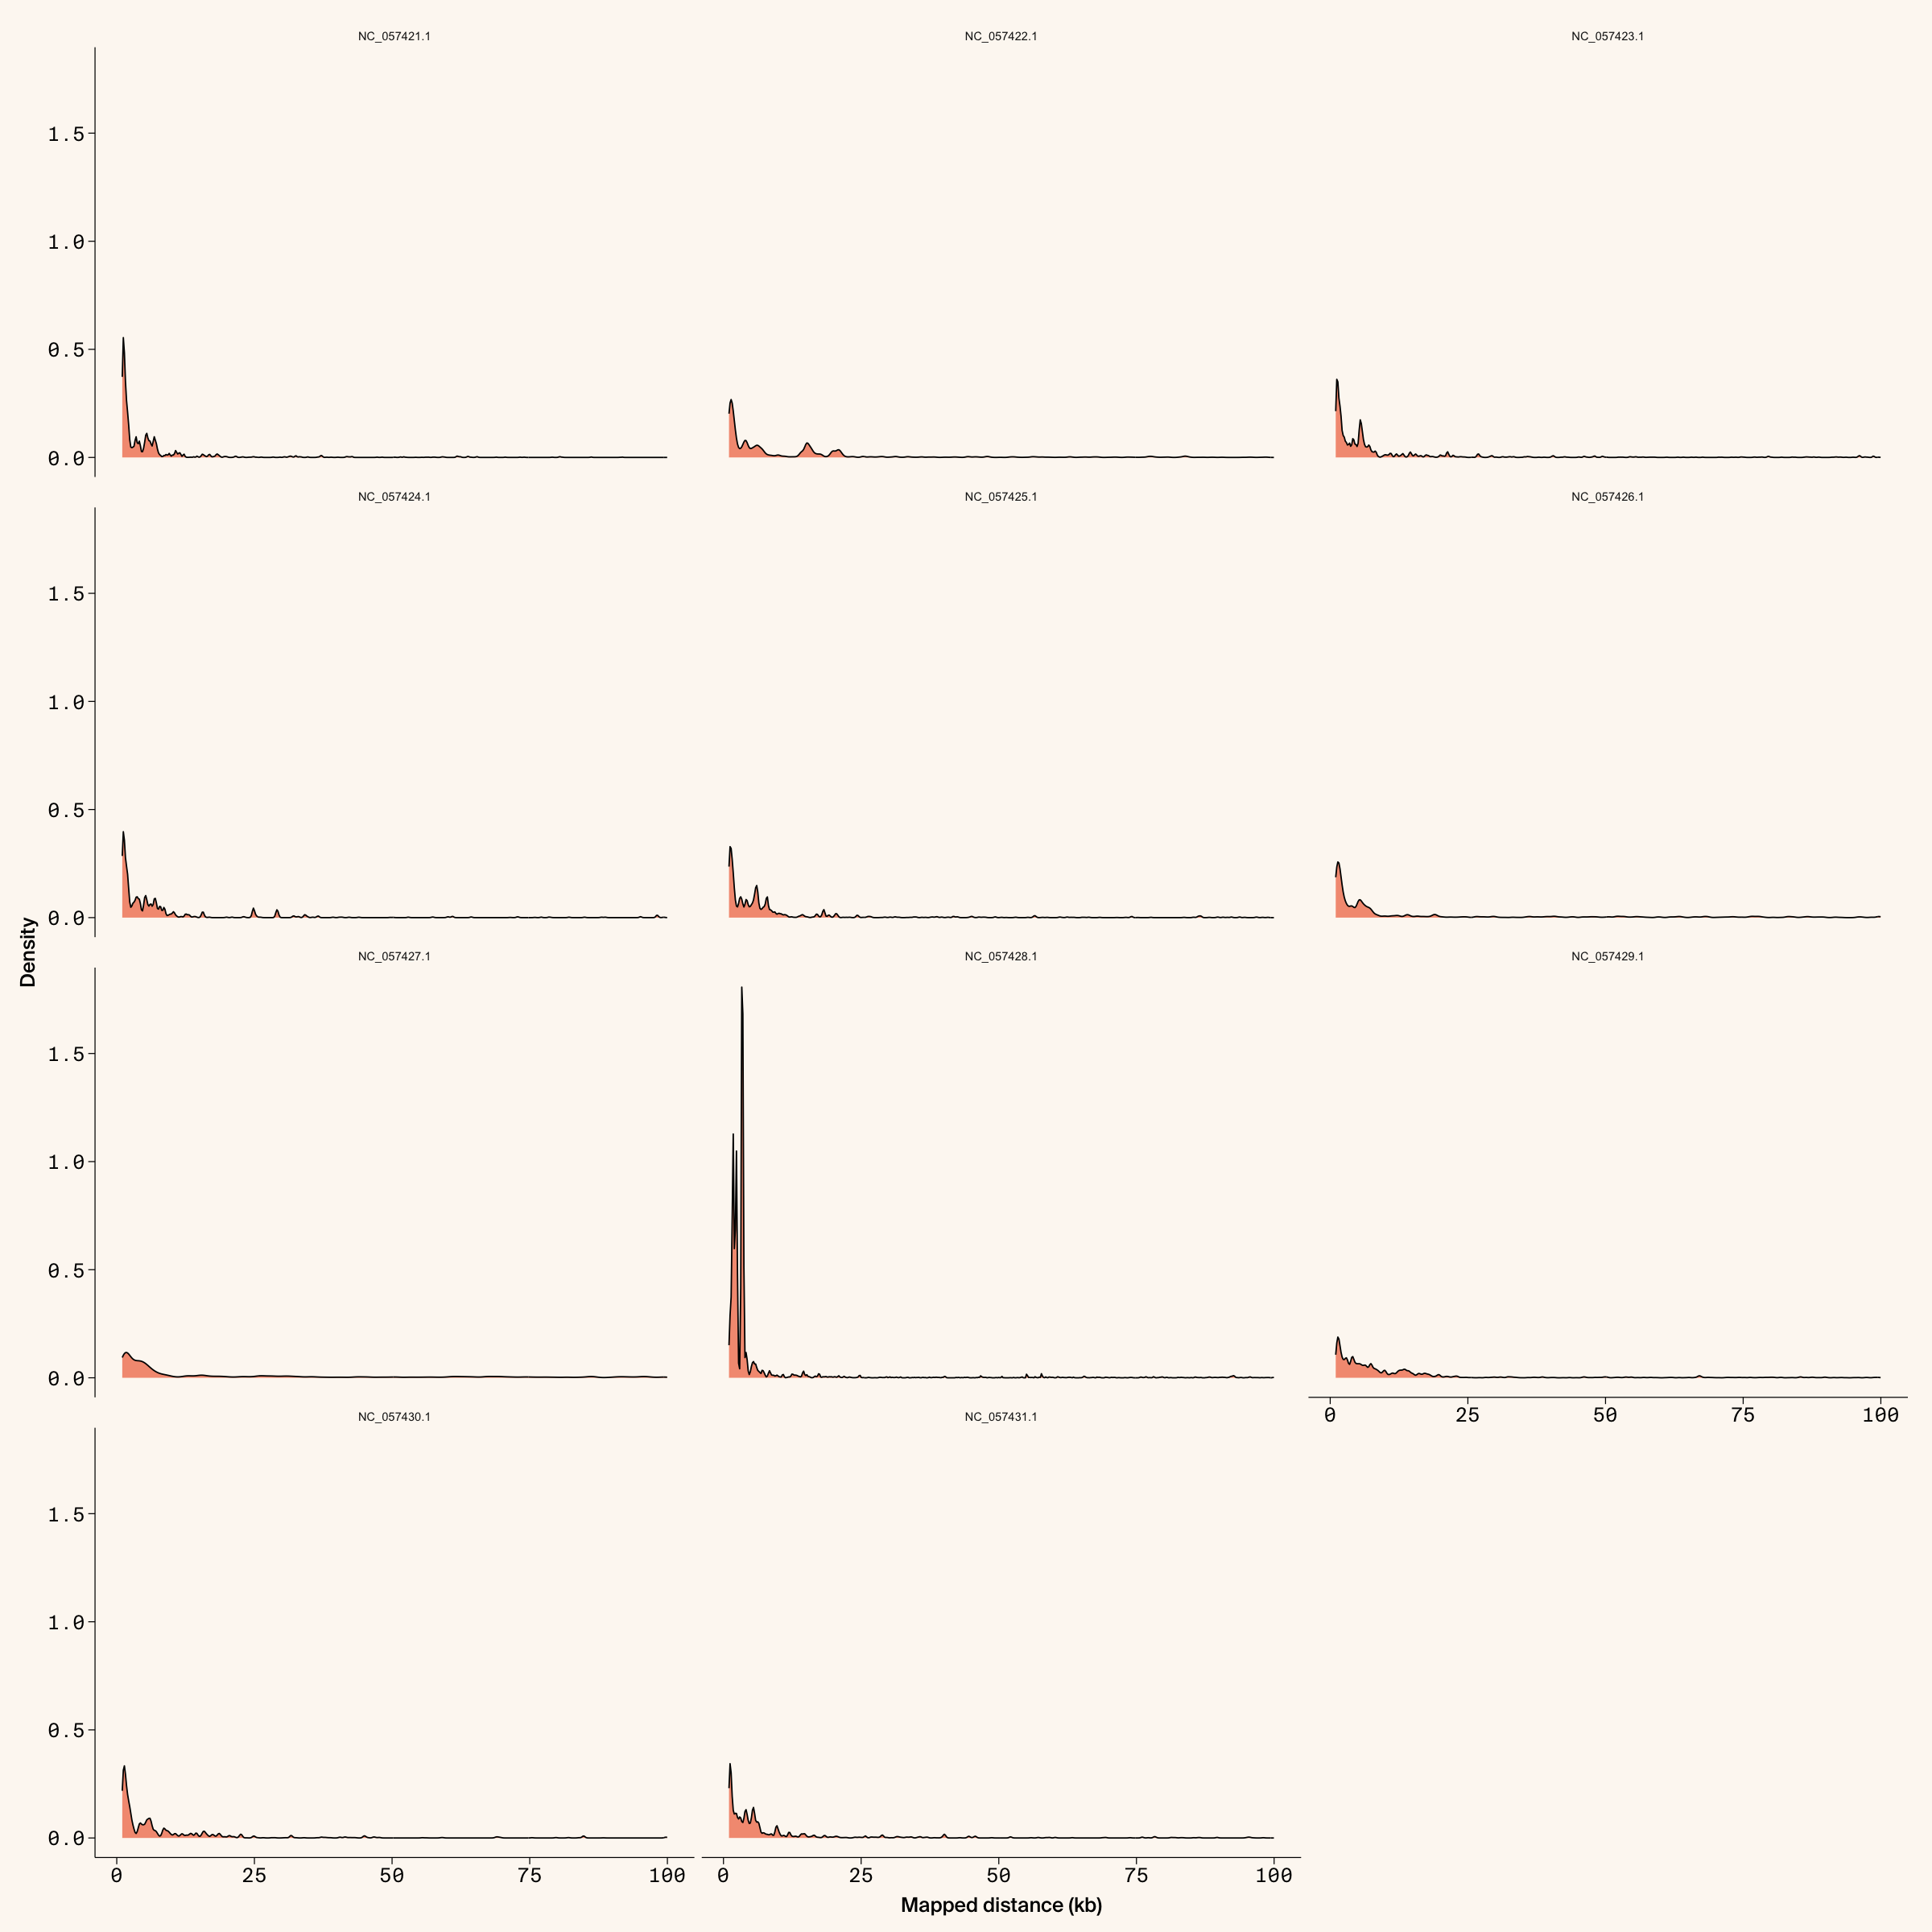

In [60]:
venturia_insert_size_plt <- venturia_dt %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000)) +
geom_density(adjust = 0.2, alpha = 0.8, fill = "#F28360") +
facet_wrap(~chromosome, nrow = 4) +
theme_arcadia() +
scale_fill_arcadia() +
labs(x = "Mapped distance (kb)", y = "Density") +
theme(legend.position = "bottom") +
guides(fill = guide_legend(""))

ggsave("results/parasitoid_wasps/fig/venturia_insert_size_density.png", venturia_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/venturia_insert_size_density.pdf", venturia_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

venturia_insert_size_plt

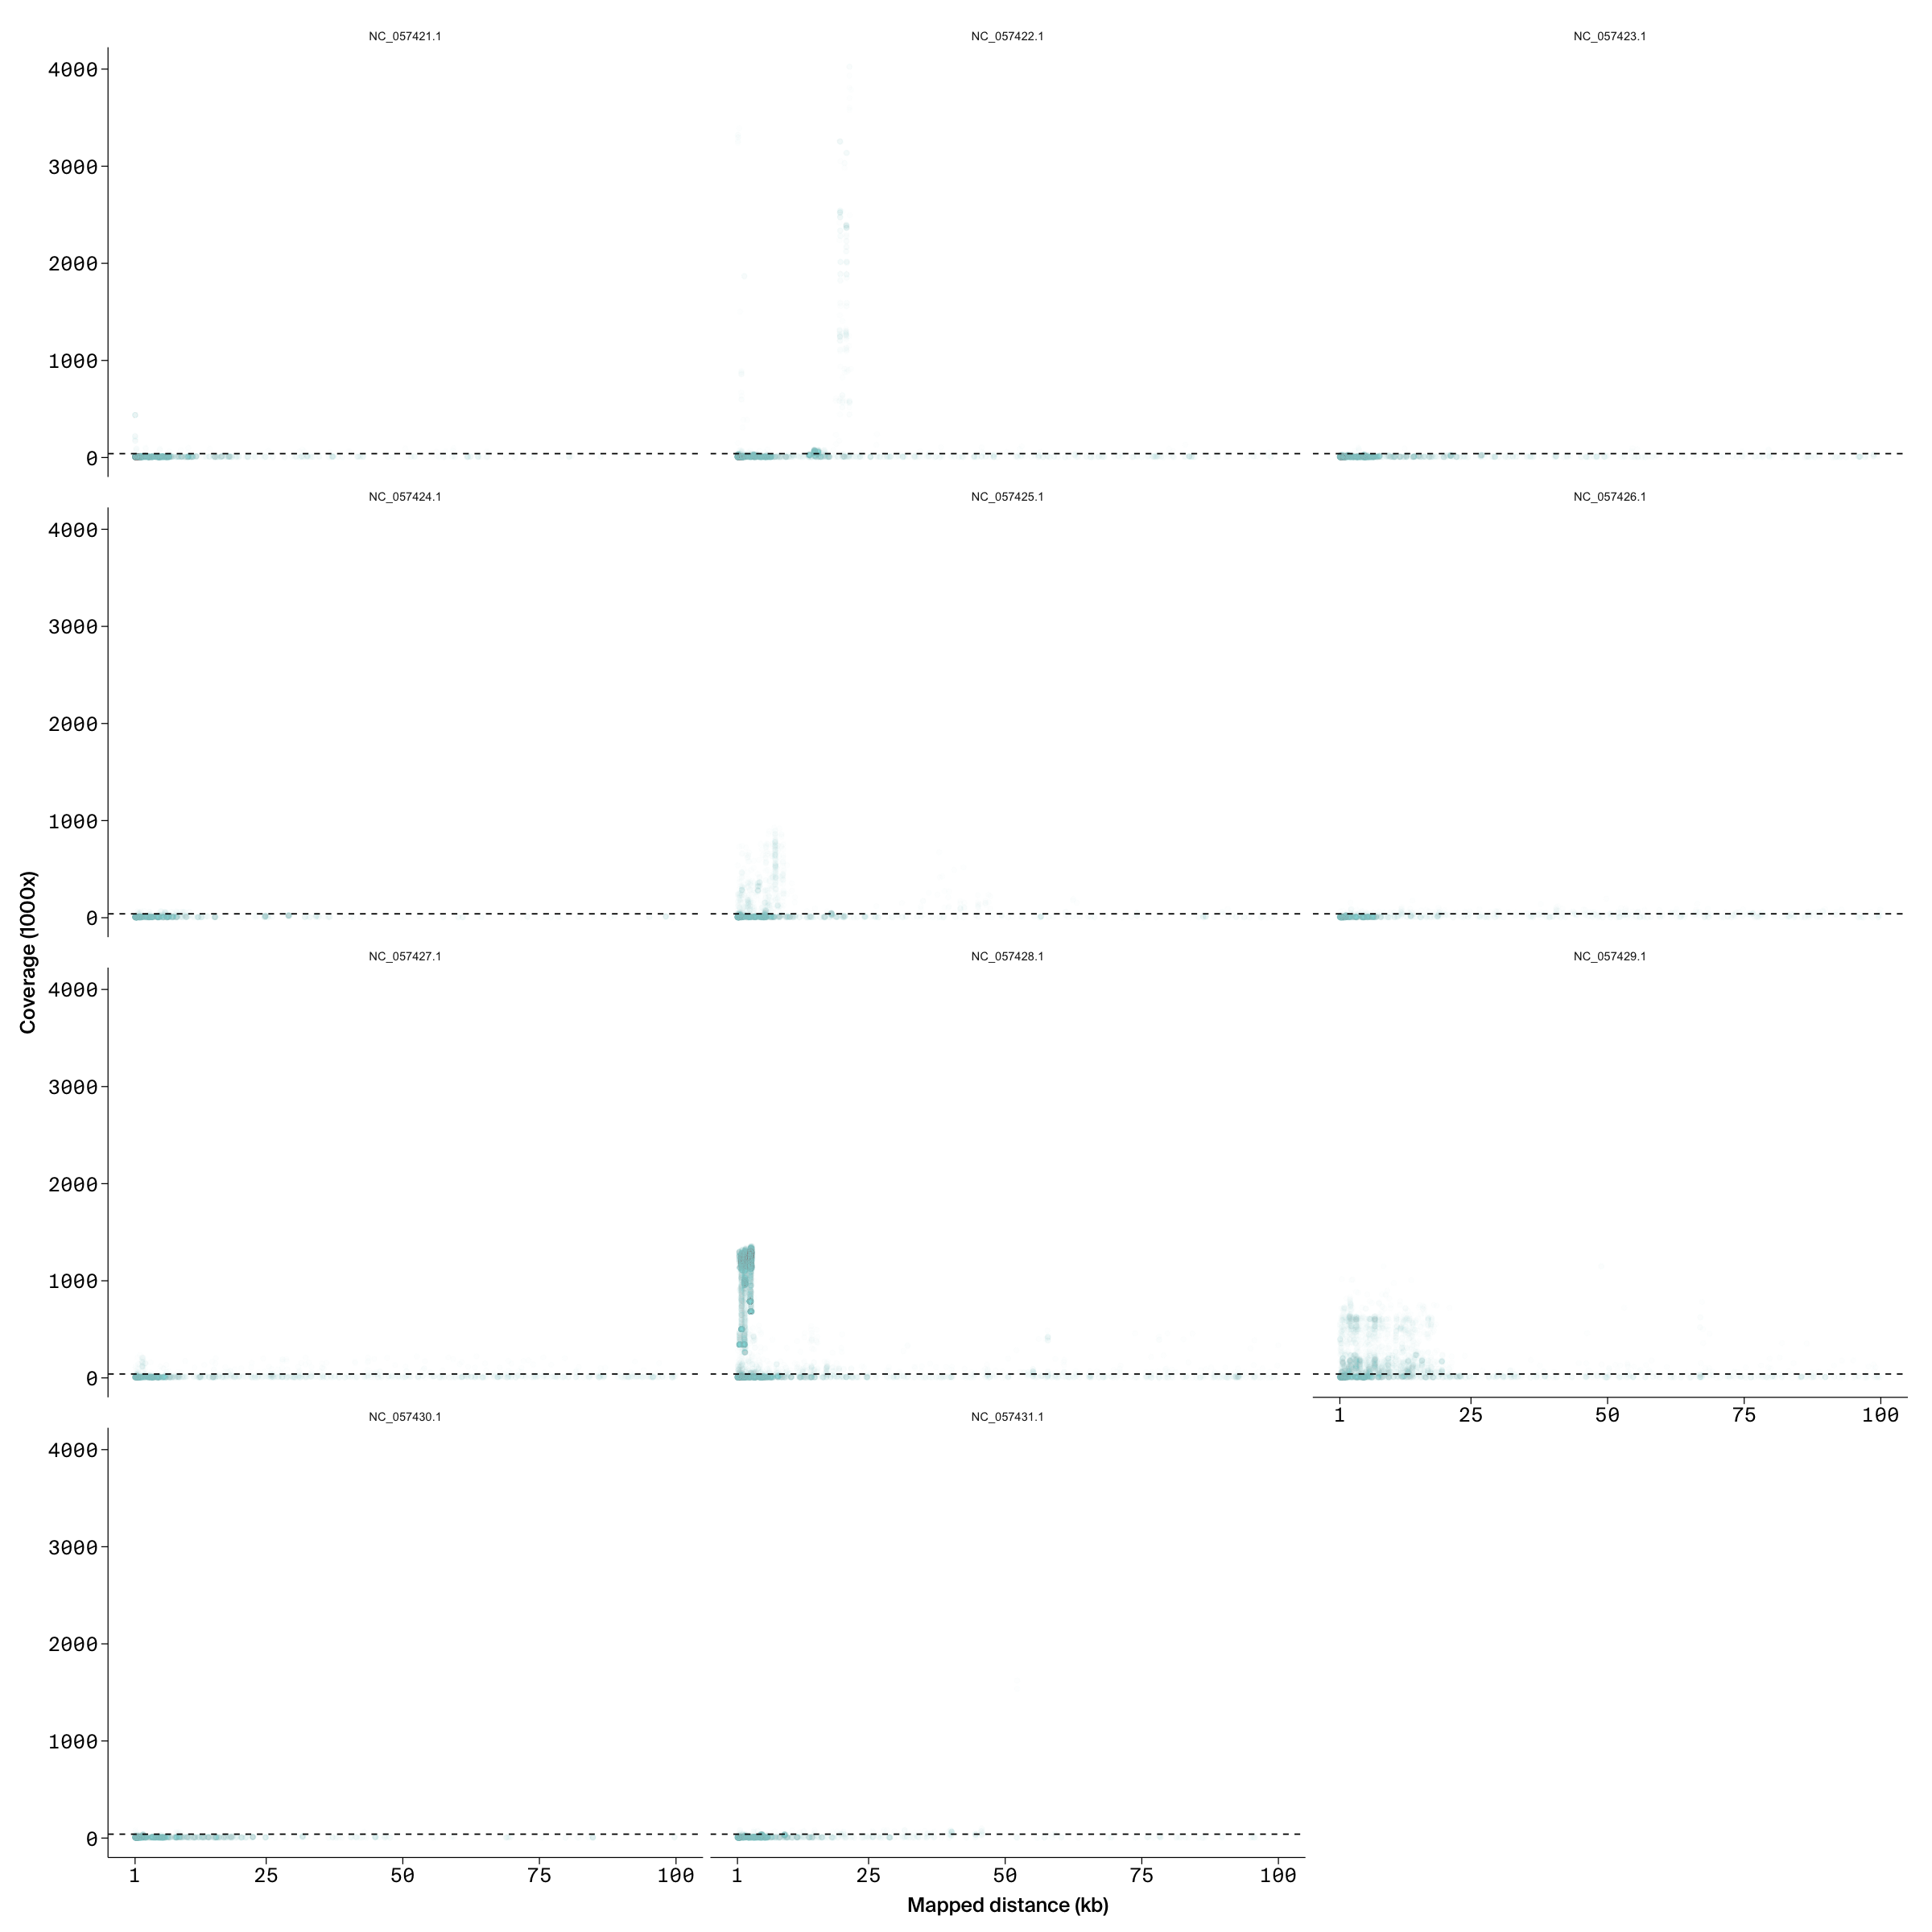

In [61]:
venturia_insert_size_by_cov_plt <- venturia_merged %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000, coverage)) +
geom_point(alpha = 0.01, color = "#6FBCAD") +
geom_hline(yintercept = 40, linetype = "dashed") + # Average genome coverage reported on NCBI
facet_wrap(~chromosome, nrow = 4) +
theme_arcadia() +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
labs(x = "Mapped distance (kb)", y = "Coverage (1000x)") +
theme(legend.position = "bottom",
panel.background = element_rect(fill='transparent'),
         plot.background = element_rect(fill='transparent', color=NA),
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(),
         legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(fill='transparent')
       )

ggsave("results/parasitoid_wasps/fig/venturia_insert_size_by_coverage.png", venturia_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/venturia_insert_size_by_coverage.png", venturia_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

venturia_insert_size_by_cov_plt

The only chromosome in _Venturia_ with mapped distance peaks is NC_057428.1. To check if this is an actual hit or a false positive, I'll filter the available annotations after looking for the most common insert.

In [71]:
venturia_inserts <- generate_insert_summary(venturia_dt) %>% find_most_common_insert()

venturia_inserts %>%
filter(rname == "NC_057428.1")

`summarise()` has grouped output by 'rname', 'insert_start_bin'. You can
override using the `.groups` argument.


rname,min_insert_start,max_insert_start,min_insert_size,max_insert_size,num_inserts
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
NC_057428.1,2569000,2570000,3000,4000,1307


The most obvious chromosome is NC_057428.1, which has high coverage and peaks. We'll look for any annotations that fall within the regions starting 2 kb before the min_insert_start and ending 2 kb after the max_insert_start + max_insert size.

In [72]:
venturia_annotations <- read.csv(paste0(INPUTS_LOC, "genome_annotations/", VENTURIA_PREFIX, "_genomic.gff"), sep = "\t", header = FALSE, comment.char = "#")

filtered_venturia_annots <- venturia_annotations %>%
filter(V1 %in% c("NC_057428.1")) %>%
# Filter to only regions within the largest insert
filter(V4 > 2569000 - 2000 & V5 < 2569000 + 4000 + 2000)

filtered_venturia_annots

V1,V2,V3,V4,V5,V6,V7,V8,V9
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
NC_057428.1,Gnomon,pseudogene,2568279,2568938,.,-,.,ID=gene-LOC122414830;Dbxref=GeneID:122414830;Name=LOC122414830;description=cytochrome c oxidase subunit 2-like;gbkey=Gene;gene=LOC122414830;gene_biotype=pseudogene;pseudo=true
NC_057428.1,Gnomon,exon,2568279,2568938,.,-,.,ID=id-LOC122414830;Parent=gene-LOC122414830;Dbxref=GeneID:122414830;gbkey=exon;gene=LOC122414830;model_evidence=Supporting evidence includes similarity to: 2 Proteins%2C and 71%25 coverage of the annotated genomic feature by RNAseq alignments;pseudo=true
NC_057428.1,Gnomon,pseudogene,2572647,2573171,.,-,.,ID=gene-LOC122414831;Dbxref=GeneID:122414831;Name=LOC122414831;description=cytochrome c oxidase subunit 1-like;gbkey=Gene;gene=LOC122414831;gene_biotype=pseudogene;pseudo=true
NC_057428.1,Gnomon,exon,2572647,2573171,.,-,.,ID=id-LOC122414831;Parent=gene-LOC122414831;Dbxref=GeneID:122414831;gbkey=exon;gene=LOC122414831;model_evidence=Supporting evidence includes similarity to: 1 Protein%2C and 79%25 coverage of the annotated genomic feature by RNAseq alignments;pseudo=true


The only two hits are to mitochondrial genes, both of which are cytochrome oxidase pseudogenes. These suggest that the insert size peaks are likely false positives. This is consistent with the idea that _V. canescens_ doesn't produce circular DNA.

#### _Cotesia congregata_ analysis

Finally, we ran the same analysis for a male-only sample of _Cotesia congregata_ to see if we could detect circular DNA in this negative control. We used the same approach as for the other species.

In [67]:
cotesia_bam_loc <- paste0(BAM_LOC, COTESIA_PREFIX, "_vs_ERR3829581.large_inserts.bam") 
# Using the filtered coverage files beacuse the unfiltered ones are too large
cotesia_cov_loc <- paste0(COV_LOC, COTESIA_PREFIX, "_vs_ERR3829581.filtered_coverage.txt")

cotesia_dt <- process_bam(cotesia_bam_loc)

# Cotesia does not have denoted chromosomes, so looking across any with >1,000 inserts
cotesia_chromosomes <- cotesia_dt %>%
group_by(rname) %>%
summarize(num_inserts = n()) %>%
filter(num_inserts > 1000) %>%
select(rname) %>%
pull(rname) %>%
unique()

cotesia_dt <- format_bam(cotesia_dt, chromosome_names = cotesia_chromosomes)

cotesia_cov <- fread(cotesia_cov_loc) %>%
format_coverage(chromosome_names = cotesia_chromosomes)

cotesia_merged <- merge(cotesia_dt, cotesia_cov, by = c("chromosome", "position"))

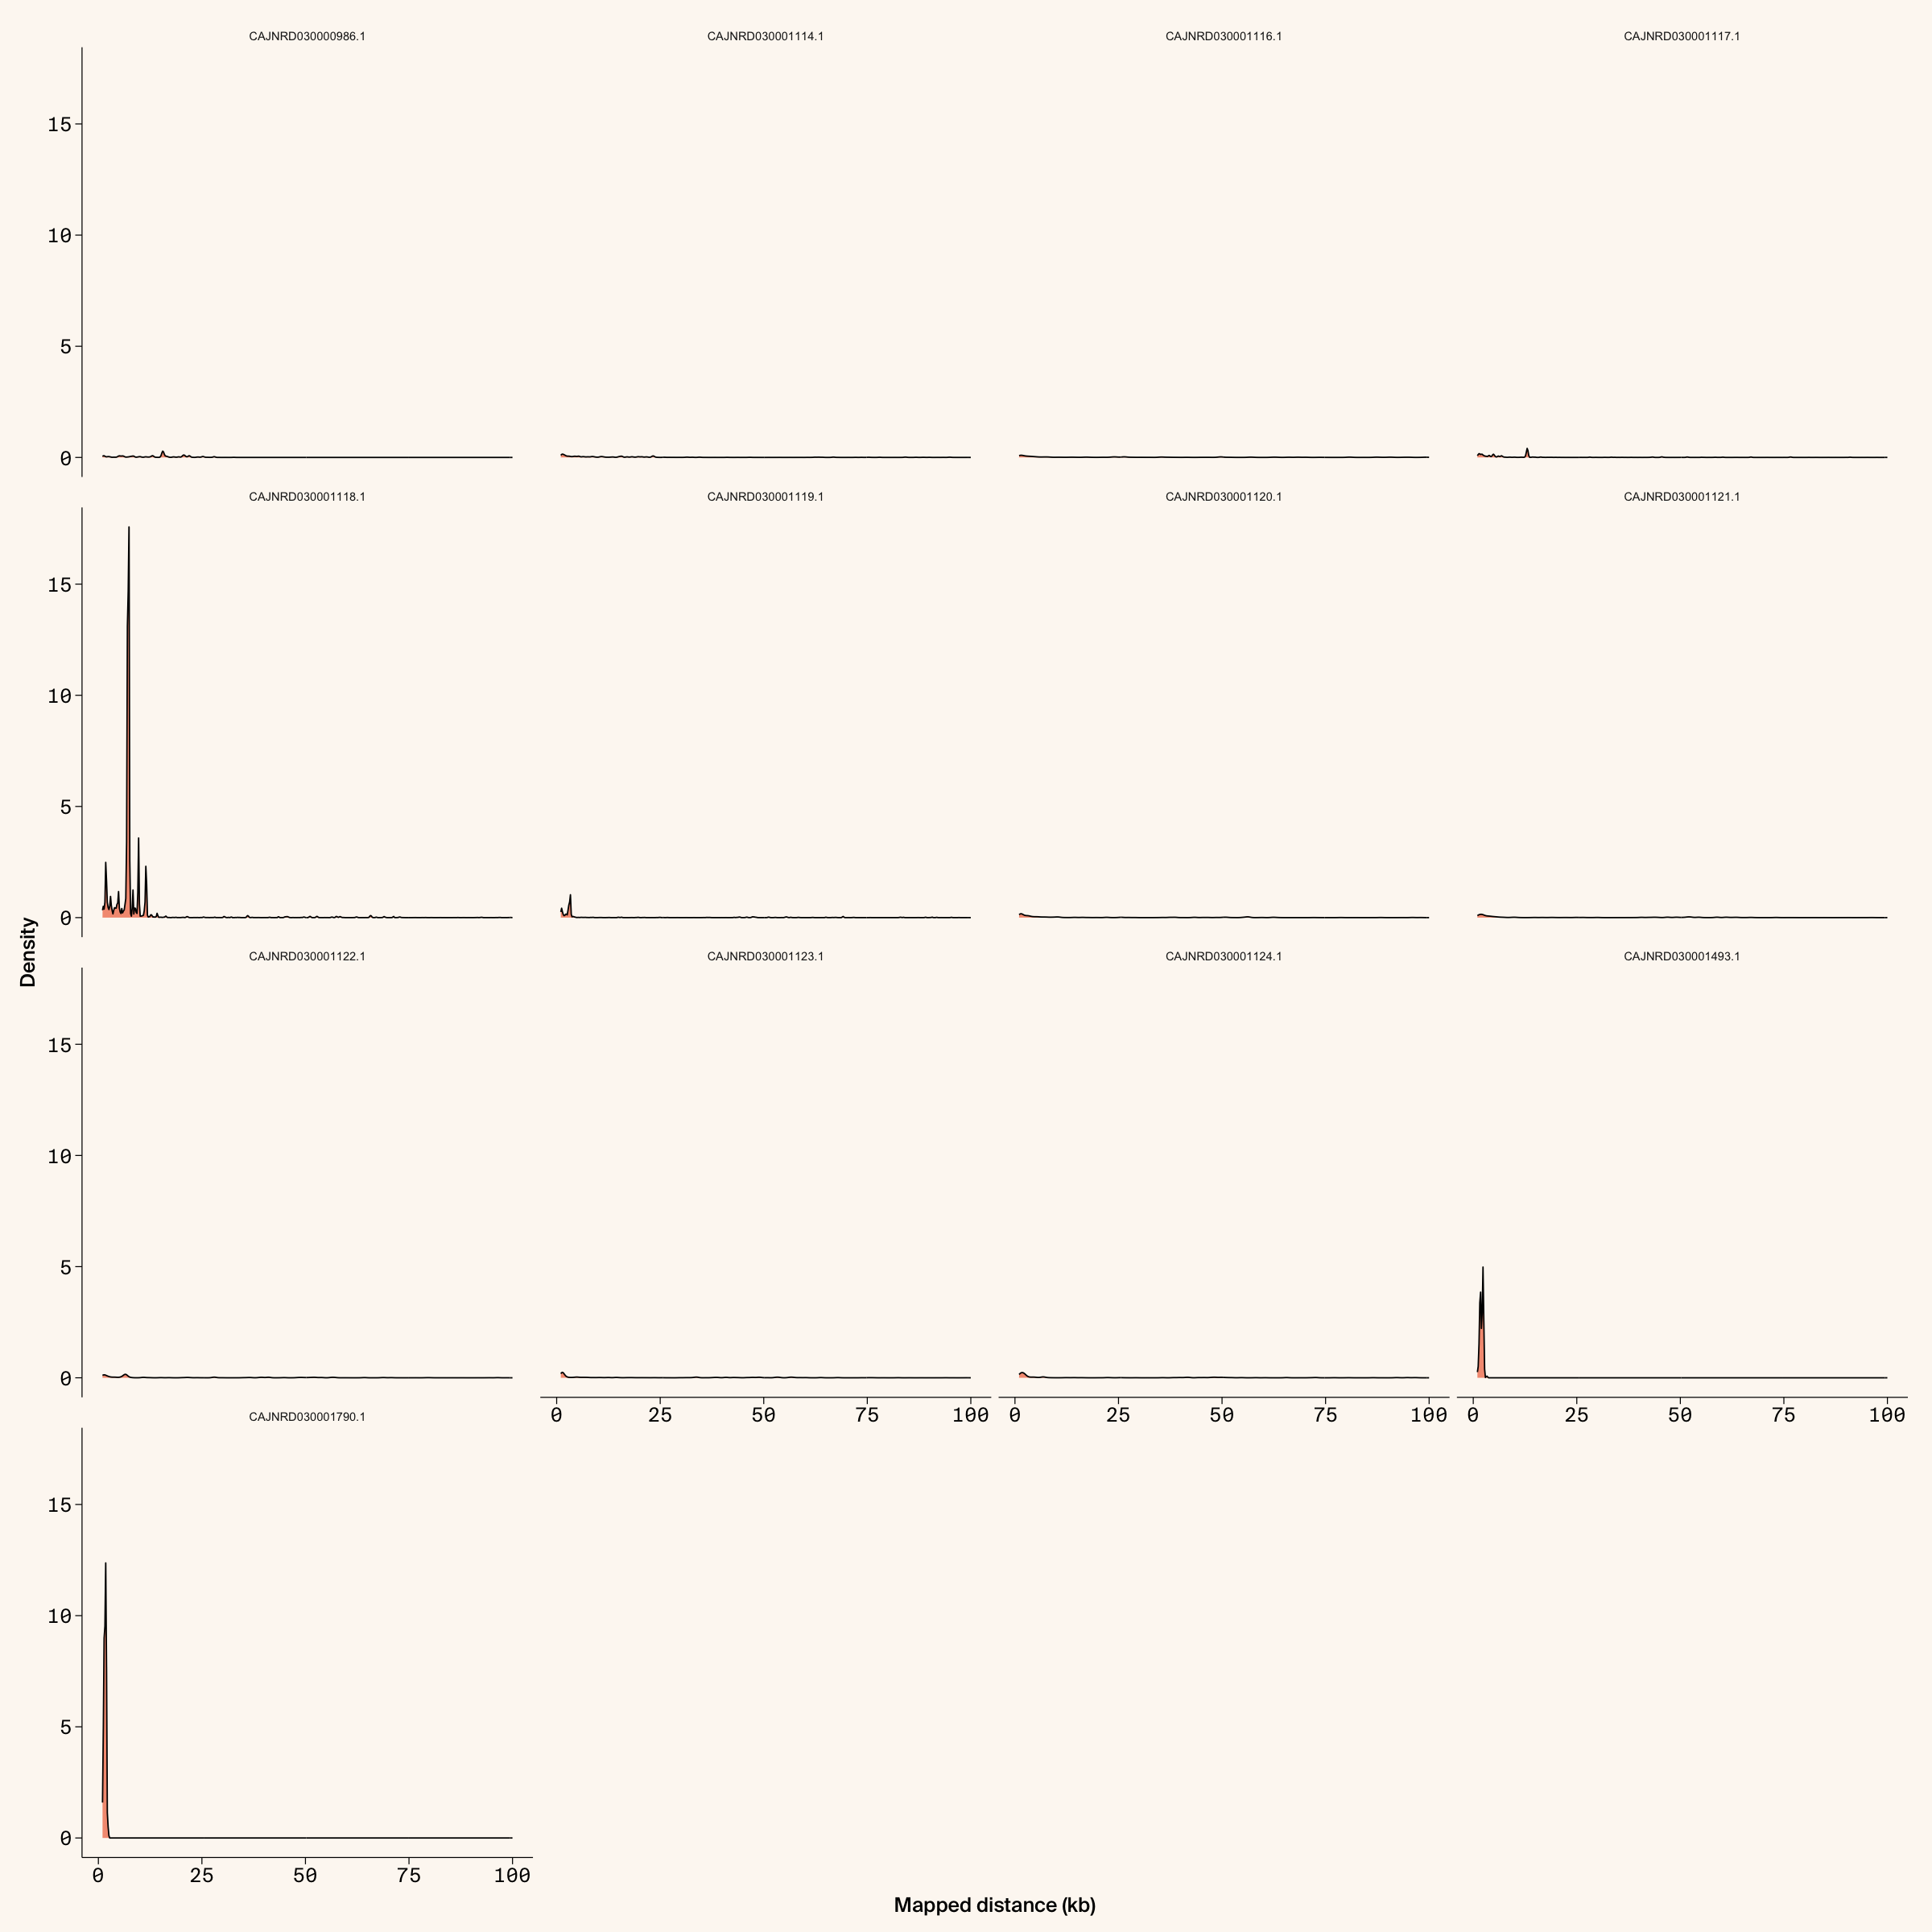

In [73]:
cotesia_insert_size_plt <- cotesia_dt %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000)) +
geom_density(adjust = 0.2, alpha = 0.8, fill = "#F28360") +
facet_wrap(~chromosome, nrow = 4) +
theme_arcadia() +
scale_fill_arcadia() +
labs(x = "Mapped distance (kb)", y = "Density") +
theme(legend.position = "bottom") +
guides(fill = guide_legend(""))

ggsave("results/parasitoid_wasps/fig/cotesia_insert_size_density.png", cotesia_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/cotesia_insert_size_density.pdf", cotesia_insert_size_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

cotesia_insert_size_plt

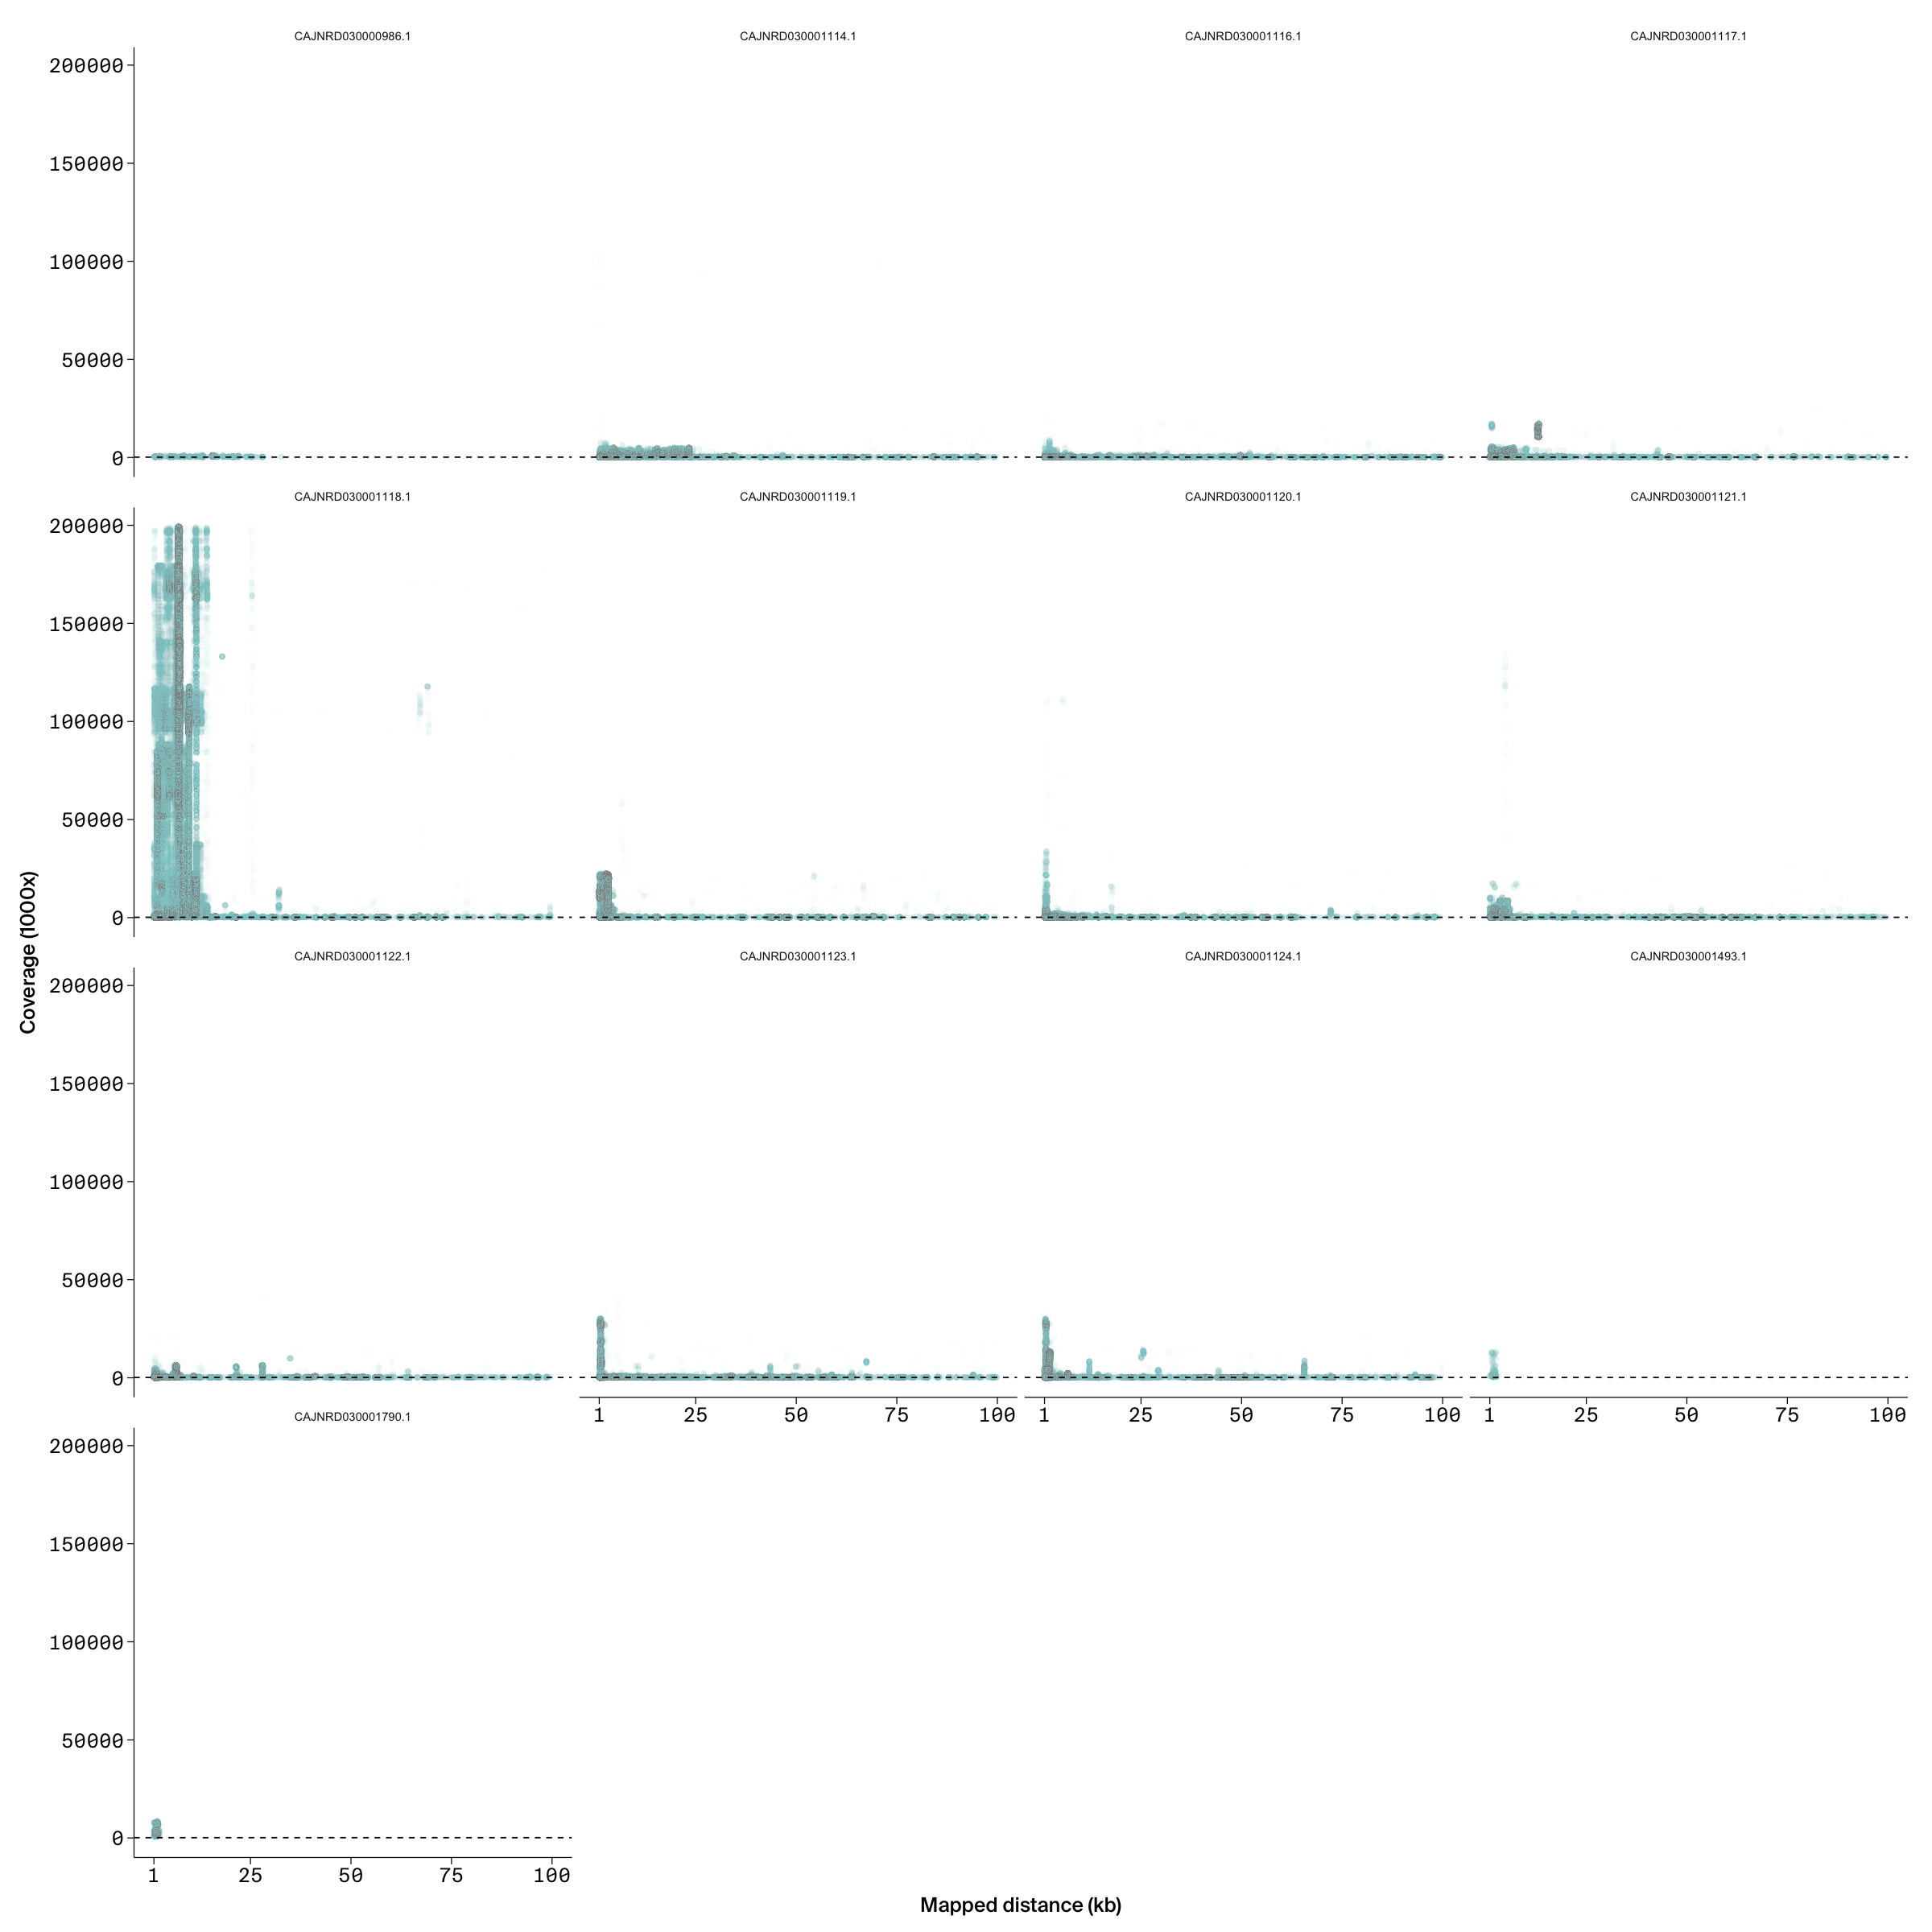

In [74]:
cotesia_insert_size_by_cov_plt <- cotesia_merged %>%
filter(isize < 100000) %>%
ggplot(aes(isize / 1000, coverage)) +
geom_point(alpha = 0.01, color = "#6FBCAD") +
geom_hline(yintercept = 157, linetype = "dashed") + # Average genome coverage reported on NCBI
facet_wrap(~chromosome, nrow = 4) +
theme_arcadia() +
scale_x_continuous(breaks = c(1, 25, 50, 75, 100), limits = c(1, 100)) +
labs(x = "Mapped distance (kb)", y = "Coverage (1000x)") +
theme(legend.position = "bottom",
panel.background = element_rect(fill='transparent'),
         plot.background = element_rect(fill='transparent', color=NA),
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(),
         legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(fill='transparent')
       )

ggsave("results/parasitoid_wasps/fig/cotesia_insert_size_by_coverage.png", cotesia_insert_size_by_cov_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)
ggsave("results/parasitoid_wasps/fig/cotesia_insert_size_by_coverage.png", cotesia_insert_size_by_cov_plt, units = "in", dpi = 300, height = 4.79 * 2, width = 4.79)

cotesia_insert_size_by_cov_plt

3 chromosomes (CAJNRD030001118.1, CAJNRD030001493.1, and CAJNRD030001790.1) have mapped distance peaks to explore, but peaks in coverage are only apparent for CAJNRD030001118.1 since the other two have relatively little associated coverage data. Like _Hyposoter_ and _Venturia_, we'll look for the most common insert size and extract the annotations from CAJNRD030001118.1.

In [75]:
cotesia_inserts <- generate_insert_summary(cotesia_dt) %>% find_most_common_insert()

cotesia_inserts %>%
filter(rname == "CAJNRD030001118.1")

`summarise()` has grouped output by 'rname', 'insert_start_bin'. You can
override using the `.groups` argument.


rname,min_insert_start,max_insert_start,min_insert_size,max_insert_size,num_inserts
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
CAJNRD030001118.1,16891000,16892000,7000,8000,138109


In [76]:
cotesia_annotations <- read.csv(paste0(INPUTS_LOC, "genome_annotations/", COTESIA_PREFIX, "_genomic.gff"), sep = "\t", header = FALSE, comment.char = "#")

filtered_cotesia_annots <- cotesia_annotations %>%
filter(V1 %in% c("CAJNRD030001118.1")) %>%
# Filter to only regions within the largest insert
filter(V4 > 16891000 - 2000 & V5 < 16891000 + 8000 + 2000)

filtered_cotesia_annots

V1,V2,V3,V4,V5,V6,V7,V8,V9
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
CAJNRD030001118.1,EMBL,exon,16900328,16900437,.,+,.,ID=exon-HICCMSTLAB_LOCUS4290-1;Parent=rna-HICCMSTLAB_LOCUS4290;Note=ID:CmstHiC_10825-RA%3B~source:maker;gbkey=mRNA;locus_tag=HICCMSTLAB_LOCUS4290;product=Protein of unknown function;standard_name=CmstHiC_10825-RA
CAJNRD030001118.1,EMBL,exon,16900722,16900905,.,+,.,ID=exon-HICCMSTLAB_LOCUS4290-2;Parent=rna-HICCMSTLAB_LOCUS4290;Note=ID:CmstHiC_10825-RA%3B~source:maker;gbkey=mRNA;locus_tag=HICCMSTLAB_LOCUS4290;product=Protein of unknown function;standard_name=CmstHiC_10825-RA
CAJNRD030001118.1,EMBL,CDS,16900361,16900437,.,+,0,ID=cds-CAG5085160.1;Parent=rna-HICCMSTLAB_LOCUS4290;Dbxref=NCBI_GP:CAG5085160.1;Name=CAG5085160.1;Note=ID:CmstHiC_10825-RA:cds%3B~source:maker;gbkey=CDS;locus_tag=HICCMSTLAB_LOCUS4290;product=Protein of unknown function;protein_id=CAG5085160.1
CAJNRD030001118.1,EMBL,CDS,16900722,16900905,.,+,1,ID=cds-CAG5085160.1;Parent=rna-HICCMSTLAB_LOCUS4290;Dbxref=NCBI_GP:CAG5085160.1;Name=CAG5085160.1;Note=ID:CmstHiC_10825-RA:cds%3B~source:maker;gbkey=CDS;locus_tag=HICCMSTLAB_LOCUS4290;product=Protein of unknown function;protein_id=CAG5085160.1
CAJNRD030001118.1,EMBL,five_prime_UTR,16900328,16900360,.,+,.,ID=id-HICCMSTLAB_LOCUS4290;Parent=gene-HICCMSTLAB_LOCUS4290;Note=ID:CmstHiC_10825-RA:five_prime_utr%3B~source:maker;gbkey=5'UTR;locus_tag=HICCMSTLAB_LOCUS4290


This is a single exon of unknown function, so it's not clear what the insert size peaks are corresponding to. However, the peak distributions are quite strange compared to _Microplitis_ and _Hyposoter_, so it's likely that this is a false positive. Additionally, it's known for _C. congregata_ that most of its proviral loci are clustered on a single chromosome - if this is the chromosome, then it would reveal an unexpected result from male-only libraries. To identify which chromosome the proviral loci-containing one is, we'll look at the annotations for any genes that include "cc_bv" in their names, since this corresponds to known proviral genes from the _C. congregata_ bracovirus.

In [81]:
cotesia_annotations %>%
filter(grepl("cc_bv", V9, ignore.case = TRUE)) %>%
group_by(V1) %>%
summarize(count = n())

V1,count
<chr>,<int>
CAJNRD030001116.1,59
CAJNRD030001118.1,3
CAJNRD030001119.1,7
CAJNRD030001120.1,429
CAJNRD030001616.1,3


It appears that CAJNRD0300001120.1 is chromosome 5, which holds most of the proviral loci. This scaffold does not have apparent insert size peaks, consistent with the idea that male-only libraries do not consistently reveal the presence of circular DNA. It's less clear what the massive amplification in CAJNRD030001118.1 is, but it is not proviral: this could warrant further investigation, but does not support the presence of circular DNA in this male-only library.

### Summary

In conclusion, we found convincing evidence for the presence of circular DNA in _Microplitis demolitor_ and _Hyposoter didymator_, and no convincing evidence for the presence of circular DNA in _Venturia canescens_ or _Cotesia congregata_. For the latter, two types of false positives are shown: mitochondrial genes and other genes of unknown function. This highlights the need to manually check the outputs of this workflow for any other organisms of interest. Overall, these results suggest that our method is effective at detecting circular DNA in parasitoid wasps, but only when samples are prepared with female wasps.